# 4 - Monte Carlo Integration (II)

##### Imports:

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import scipy.stats as stats 
import time

The following package is installed to easily create dataframes.

In [2]:
import pandas as pd

##### Configure matplotlib settings

In [3]:
plt.style.use('ggplot')
plt.rcParams.update(
    {"text.usetex": True,
     "font.serif": "Modern Roman",
     "figure.figsize": (10, 8),
     "axes.titlesize" : 26,
     "axes.labelsize" : 28,
     "lines.linewidth": 3,
     "lines.markersize" : 10,
     "legend.fontsize":20,
     "xtick.labelsize" : 24,
     "ytick.labelsize" : 24})

In [4]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

##### Functions:

In [5]:
def radius(x): 
    '''Calculates the radial component of a vector'''
    return np.sqrt(np.dot(x, x))

In [6]:
def flip_coin(p):
    '''Return True with probability p, return false with probability 1-p'''
    x = random.uniform(0, 1)
    if x <= p:
        return True
    else:
        return False

In [7]:
def update_pos(pos, h):
    '''Updates the position according to metropolis algorithm described in the exercise'''
    
    delta = np.array([random.uniform(-h/2, h/2), random.uniform(-h/2, h/2), random.uniform(- h/2, h/2)])
    newpos = pos + delta
    if  (radius(newpos))**2 < (radius(pos))**2:
        return newpos
    else:
        A = np.exp(-0.5*((radius(newpos))**2 - (radius(pos))**2))  # acceptance ratio
        if flip_coin(A) == True:
            return newpos
        else:
            return pos

In [8]:
def get_random_walk(nstep, h, start_pos = np.array([0, 0, 0])):
    walk = [start_pos]
    for step in range(nstep):
        newpos = update_pos(walk[-1], h)
        walk.append(newpos)
    return walk

In [9]:
def gaussian(t, mu = 0, sigma = 1):
    return 1/(sigma*np.sqrt(2*np.pi))*np.exp(-((t-mu)/sigma)**2/2)

In [10]:
def approximate_integral(npts, nrep, h, start_pos = np.array([0, 0, 0])):
    '''Numerical approximation of the integral using Metropolis algorithm. See exercise 4.2'''
    I = []
    pos = start_pos
    
    for k in range(nrep):
        s = 0
        for i in range(npts):
            if i == 0:
                x, y, z = start_pos[0], start_pos[1], start_pos[2]
                s+= g(x, y, z)

            else:
                newpos = update_pos(pos, h)
                x, y, z = newpos[0], newpos[1], newpos[2]
                s += g(x, y, z)
                
                pos = newpos
            
        I.append(s*(2*np.pi)**1.5/npts)
    return I

In [11]:
def steps_integral(nstep, h, start_pos = np.array([0, 0, 0])):
    '''Saves all the intermediate steps when calculating the approximation for the integral. Useful for exercise 4.3.'''
    I = []
    s = []
    pos = start_pos
    
    for i in range(nstep):
        if i == 0:
            x, y, z = start_pos[0], start_pos[1], start_pos[2]
            value = g(x,  y, z)
            
            s.append(value)
            I.append(value*(2*np.pi)**1.5)
        
        else:
            newpos = update_pos(pos, h)
            x, y, z = newpos[0], newpos[1], newpos[2]
        
            s.append(s[-1] + g(x, y, z))
            new_val = (s[-1]*(2*np.pi)**1.5)/(i+1) 
            I.append(new_val)
        
            pos = newpos
    return I

Store the exact value of the integral (see section 3):

In [12]:
exact = 3*(2*np.pi)**1.5

## 4.1 - Trajectories


In [13]:
nstep = 10**4

### 4.1.1 - Trajectory from $\mathbf{r}_0 = (0, 0, 0)$

Starting position: origin. Note that the function $\texttt{get_random_walk}$ takes the origin by default as starting position. 

In the next command block, I change the width of the lines with which matplotlib plots, since otherwise the figure is a mess.

In [14]:
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.linestyle'] = '--'
plt.rcParams['lines.markersize'] = 3

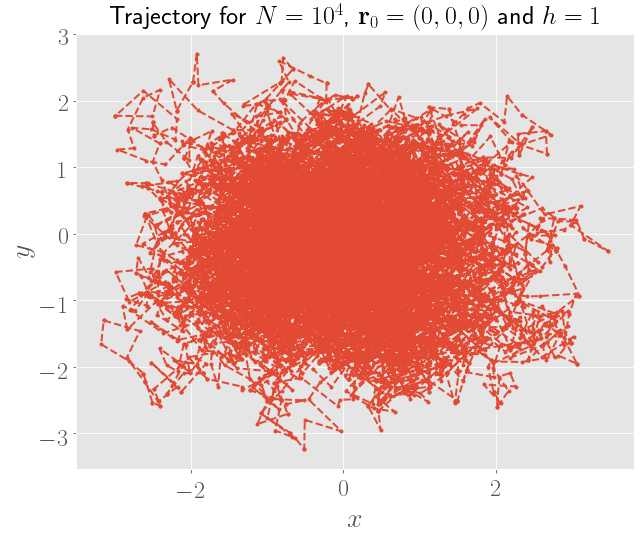

In [15]:
h = 1
walk = get_random_walk(nstep, h)
x = [v[0] for v in walk]; y = [v[1] for v in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (0, 0, 0)$ and $h = 1$')
plt.savefig('ex4_origin_h1.pdf', bbox_inches = 'tight')
plt.show()

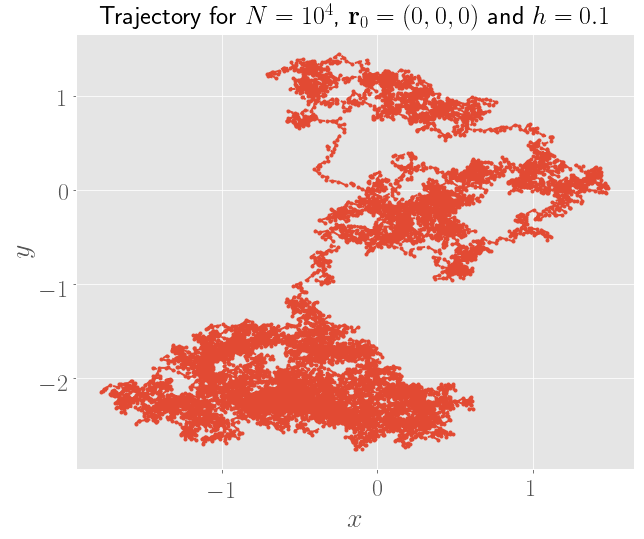

In [16]:
h = 0.1
walk = get_random_walk(nstep, h)
x = [pos[0] for pos in walk]; y = [pos[1] for pos in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (0, 0, 0)$ and $h = 0.1$')
plt.savefig('ex4_origin_h01.pdf', bbox_inches = 'tight')
plt.show()

## 4.1.2 - Trajectory from $\mathbf{r}_0 = (10, 10, 10)$

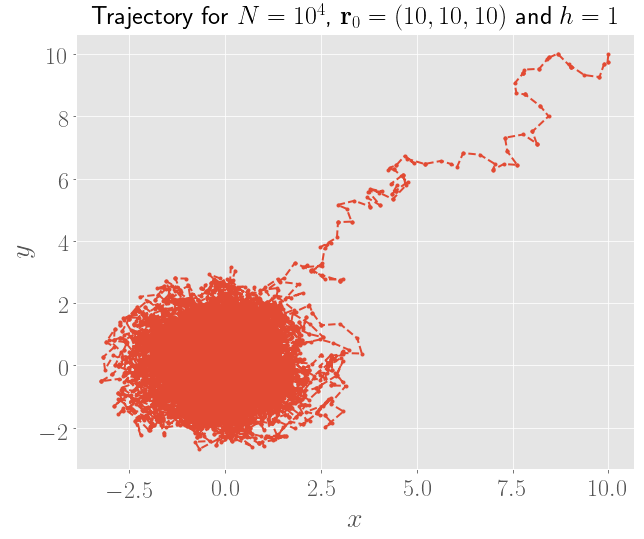

In [17]:
h = 1; start_pos = np.array([10, 10, 10])
walk = get_random_walk(nstep, h, start_pos)
x = [pos[0] for pos in walk]; y = [pos[1] for pos in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (10, 10, 10)$ and $h = 1$')
plt.savefig('ex4_away_h1.pdf', bbox_inches = 'tight')
plt.show()

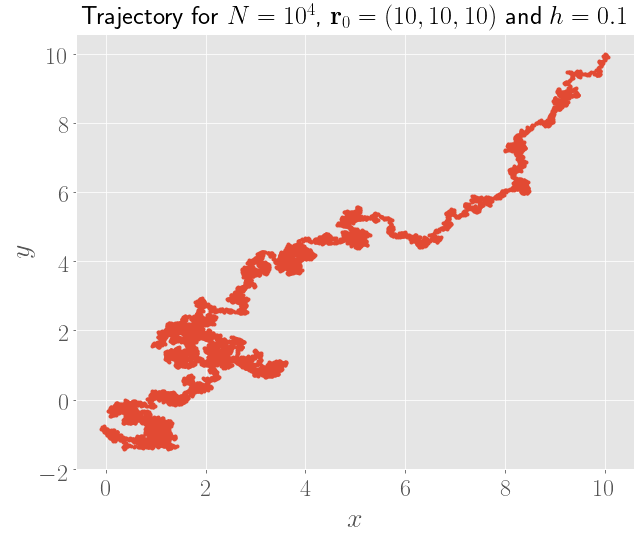

In [18]:
h = 0.1;  start_pos = np.array([10, 10, 10])
walk = get_random_walk(nstep, h, start_pos)
x = [pos[0] for pos in walk]; y = [pos[1] for pos in walk]

plt.plot(x, y, marker = 'o')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'Trajectory for $N = 10^4$, $\mathbf{r}_0 = (10, 10, 10)$ and $h = 0.1$')
plt.savefig('ex4_away_h01.pdf', bbox_inches = 'tight')
plt.show()

### 4.2.1 - Histogram of positions: for $\mathbf{r}_0 = (0, 0, 0)$

Change the matplotlib configurations again.

In [19]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.linestyle'] = '-'
plt.rcParams['lines.markersize'] = 3

In [20]:
# Get a random walk for nstep = 10^6
nstep = 10**6; h = 1

walk =get_random_walk(nstep, h)
xdata = [v[0] for v in walk]; ydata = [v[1] for v in walk]; zdata = [v[2] for v in walk]

In [21]:
# Obtain magnitudes of positions
distances = [radius(pos) for pos in walk]

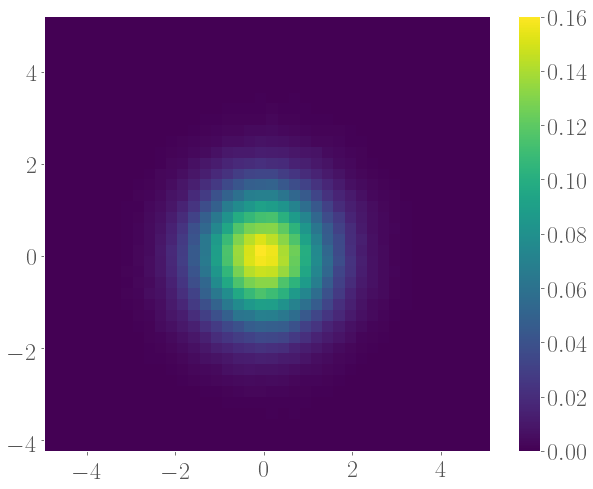

In [27]:
plt.hist2d(xdata, ydata, normed= True, bins = 40)
plt.colorbar()
plt.show()

$\textbf{FOLLOWING CURVE IS USELESS}$

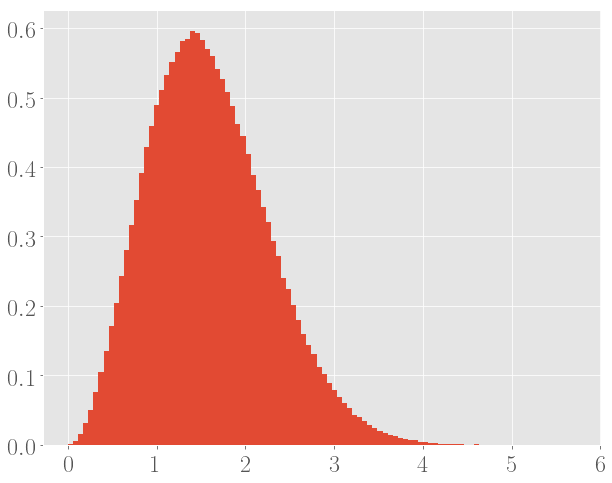

In [22]:
plt.hist(distances, density = True, bins = 100)
plt.show()

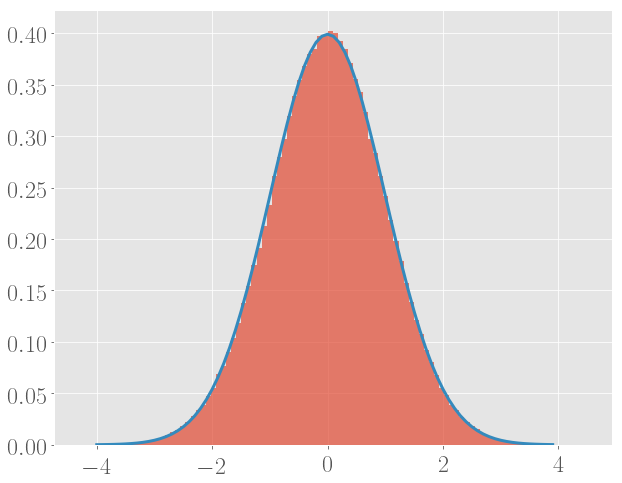

In [23]:
plt.hist(xdata, density = True, bins = 100, alpha = 0.7)
t = np.arange(-4, 4, 0.1)
y = gaussian(t)
plt.plot(t, y, label = 'Standard Gaussian curve')
plt.show()

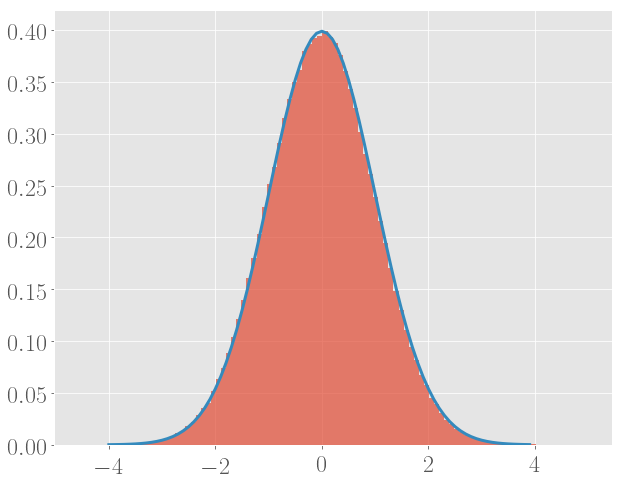

In [24]:
plt.hist(ydata, density = True, bins = 100, alpha = 0.7)
t = np.arange(-4, 4, 0.1)
y = gaussian(t)
plt.plot(t, y, label = 'Standard Gaussian curve')
plt.show()

## 4.2 - Numerical integration

In [28]:
#Number of points per run: npts
#Number of replicas: nrep
npts = 10**3; nrep = 100;

See exercise 3: the function we use to approximate the integral using our Monte Carlo methods was $g(x,y,z)$ given by:

In [29]:
def g(x, y, z):
    return (x + y + z)**2

We look for the optimal value of $h$.

In [199]:
column_names =  ['h value', 'Difference', 'Fluctuations']
df = pd.DataFrame(columns = column_names)

In [201]:
h_list = np.arange(0.4, 0.9, 0.1)

for h in h_list:
    I = approximate_integral(npts, nrep, h)
    delta = abs(np.mean(I) - exact)
    fluct = np.std(I)/np.mean(I)
    
    new_row = pd.DataFrame([[h, delta, fluct]], columns = column_names)
    df = df.append(new_row, ignore_index = True)

In [202]:
df

,h value,Difference,Fluctuations
0,0.4,1.183156,0.582460
1,0.5,1.214587,0.406277
2,0.6,0.442490,0.383286
3,0.7,0.399929,0.324882
4,0.8,4.479967,0.333294


In [203]:
h_list = np.arange(0.71, 0.79, 0.01)

for h in h_list:
    I = approximate_integral(npts, nrep, h)
    delta = abs(np.mean(I) - exact)
    fluct = np.std(I)/np.mean(I)
    
    new_row = pd.DataFrame([[h, delta, fluct]], columns = column_names)
    df = df.append(new_row, ignore_index = True)

In [204]:
df = df.sort_values(by=['h value'])
x = df['h value']; y = df['Difference']; yerr = df['Fluctuations'];

In [205]:
df

,h value,Difference,Fluctuations
0,0.40,1.183156,0.582460
1,0.50,1.214587,0.406277
2,0.60,0.442490,0.383286
3,0.70,0.399929,0.324882
5,0.71,2.095097,0.333290
6,0.72,0.509633,0.357962
7,0.73,0.127898,0.376407
8,0.74,2.266614,0.331004
9,0.75,1.337465,0.348824
10,0.76,1.384617,0.375945


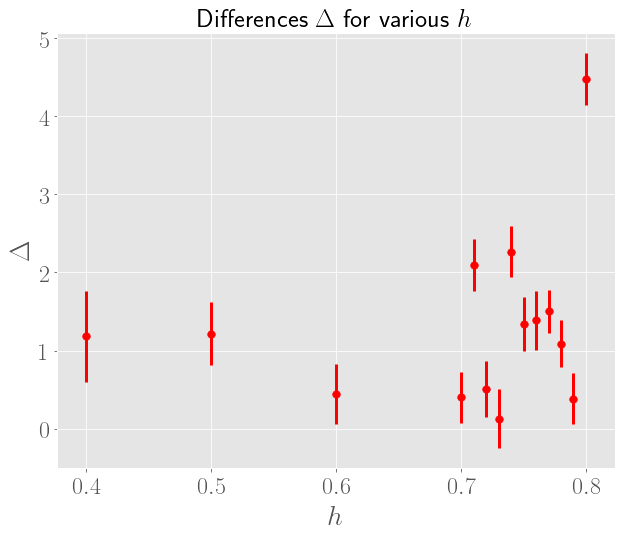

In [206]:
# Plot the full graph
plt.errorbar(x, y, yerr, fmt = ' ', color = 'red')
plt.scatter(x, y, color = 'red', marker = 'o', s = 60)

plt.xlabel(r'$h$')
plt.ylabel(r'$\Delta$')
plt.title(r'Differences $\Delta$ for various $h$')
plt.show()

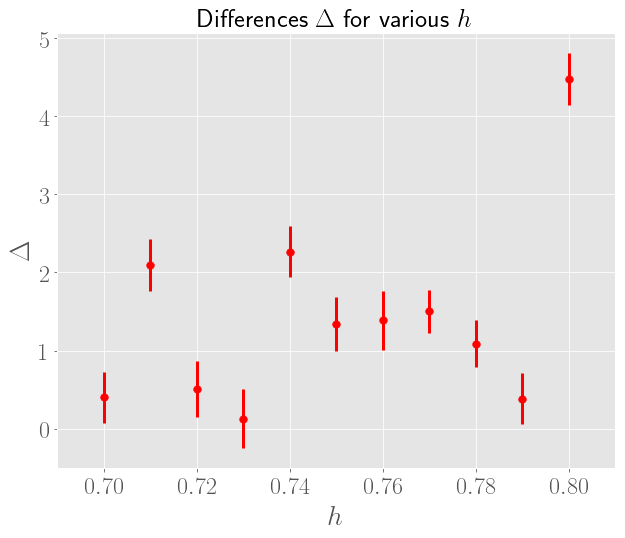

In [207]:
# Zoom in between x = 0.7 and x = 0.8
x[0]
plt.errorbar(x[1:], y[1:], yerr[1:], fmt = ' ', color = 'red')
plt.scatter(x, y, color = 'red', marker = 'o', s = 60)
plt.xlim(0.69, 0.81)
plt.xlabel(r'$h$')
plt.ylabel(r'$\Delta$')
plt.title(r'Differences $\Delta$ for various $h$')
plt.show()

## 4.3 - Equilibration 

Let us first see for starting position at the origin.

In [35]:
nstep = 10**4; h = 1
I = steps_integral(nstep, h)

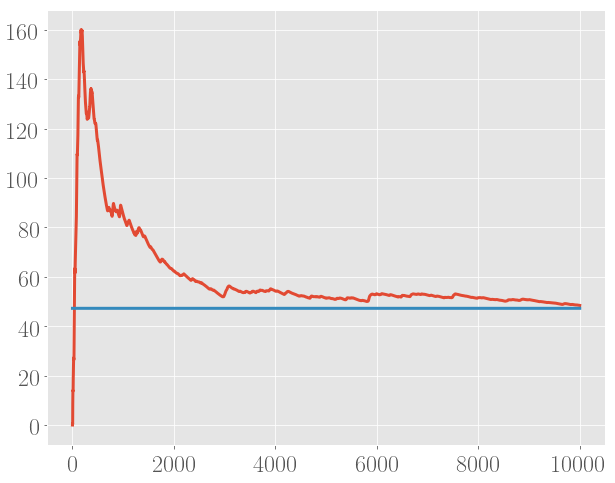

In [36]:
plt.plot(I)
plt.plot([exact for i in range(nstep)])
#plt.xlim(0, 2000)
plt.show()

In [94]:
nstep = 10**6; h = 1
start_pos = np.array([10, 10, 10])

I = steps_integral(nstep, h, start_pos)

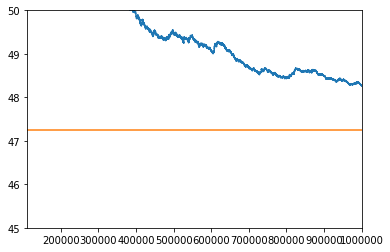

In [100]:
plt.plot([i for i in range(nstep)], I)
plt.plot([i for i in range(nstep)], [exact for i in range(nstep)])
plt.xlim(110000, nstep)
plt.ylim(45, 50)
plt.show()

In [ ]:
I2 = approximate_integral(nstep, nrep, )

## BONUS: Random Walk animation

In [29]:
def run(i):
    global walk
    # first frame
    if i == 0:
        line, = ax.plot([], [], lw=2)
        #ax.plot(0, 0)
        return line

    # update:
    newpos = update_pos(walk[-1], h)
    walk.append(newpos)
    
    # data
    xdata = [pos[0] for pos in walk]
    ydata = [pos[1] for pos in walk]
    
    # new bounds:
    ax.set_xlim(min(-1, min(xdata) - 1), max(1, max(xdata) + 1))
    ax.set_ylim(min(-1, min(ydata) - 1), max(1, max(ydata) + 1))
    
    # redraw the plot
    line, = ax.plot([], [], lw=2)
    line.set_data(xdata, ydata)
    ax.plot(walk[-1][0], walk[-1][1])
  
    return line

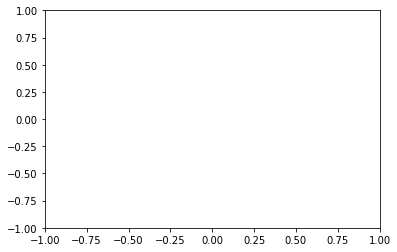

In [30]:
# Create an animation for a random walk
walk = [np.array([0, 0, 0])] # starting point

fig, ax = plt.subplots()
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
anim = animation.FuncAnimation(fig, run, frames = 400, interval=20)

Uncomment the next code block to get the animation. Note: takes some time!

In [31]:
# HTML(anim.to_jshtml()) # uncomment this to generate the animation Warning: takes a bit of time - play around with 'frames' to change this